https://github.com/wradlib/wradlib-notebooks/blob/main/notebooks/beamblockage/beamblockage.ipynb

This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

Beam Blockage Calculation using a DEM

Here, we derive (**p**artial) **b**eam-**b**lockage (**PBB**) from a **D**igital **E**levation **M**odel (**DEM**).

# Preparação do ambiente
- the local radar setup (sitecoords, number of rays, number of bins, antenna elevation, beamwidth, and the range resolution);
- a **DEM** with a adequate resolution.

Here we use pre-processed data from the [GTOPO30](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-30-arc-second-elevation-gtopo30) and [SRTM](https://www2.jpl.nasa.gov/srtm/index.html) missions.

In [1]:
!pip install -q wradlib
!pip install -q wradlib-data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.6 MB/s eta 0:00:00


In [2]:
import wradlib as wrl
import wradlib_data
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/MyDrive/6-COMPRA_RADAR/02_CODIGOS'

Mounted at /content/drive


# Setup for radar

First, we need to define some radar specifications (here: *University of Bonn*).

In [33]:
"""
sitecoords = (7.071663, 50.73052, 99.5)
nrays = 360        # number of rays
nbins = 1000       # number of range bins
el = 1.0           # vertical antenna pointing angle (deg)
bw = 1.0           # half power beam width (deg)
range_res = 100.0  # range resolution (meters)
"""

lat_itajuba, lon_itajuba = -22.42, -45.45

lat_radar, lon_radar, alt_radar = -22.5344, -45.5825, 1850
sitecoords = (lon_radar, lat_radar, alt_radar)  # (longitude, latitude, altitude)
nrays = 360                                     # number of rays
nbins = 960                                     # number of range bins
el = 0.5                                        # vertical antenna pointing angle (deg) SIMULATED
bw = 0.5                                        # half power beam width (deg) obs. atentar que é metade
range_res = 250                                 # range resolution (meters)

lat_radar, lon_radar, alt_radar = -22.5344, -45.5825, 1850
sitecoords = (lon_radar, lat_radar, alt_radar)  # (longitude, latitude, altitude)
nrays = 360                                     # number of rays
nbins = 666                                     # number of range bins
el = -0.5                                        # vertical antenna pointing angle (deg) SIMULATED
el = 0.0
el = 0.5

radar_beam_width = 1.3
bw = radar_beam_width/2.                        # half power beam width (deg) obs. atentar que é metade

range_res = 150                                 # range resolution (meters)

Create the range, azimuth, and beamradius arrays.

In [34]:
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

We use

- [wradlib.georef.sweep_centroids](https://docs.wradlib.org/en/latest/generated/wradlib.georef.polar.sweep_centroids.html)  and
- [wradlib.georef.spherical_to_proj](https://docs.wradlib.org/en/latest/generated/wradlib.georef.polar.spherical_to_proj.html)

to calculate the spherical coordinates of the bin centroids and their longitude, latitude and altitude.

In [35]:
coord = wrl.georef.sweep_centroids(nrays,
                                   range_res,
                                   nbins,
                                   el)

coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                      coord[..., 1],
                                      coord[..., 2],
                                      sitecoords)

lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

In [36]:
polcoords = coords[..., :2]
print("lon,lat,alt:", coords.shape)

lon,lat,alt: (360, 666, 3)


In [37]:
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f"  % (lat.max(), lon.min(), lon.max(), lat.min())
)

Radar bounding box:
	-21.63
-46.55             -44.61
	-23.44


# Preprocessing the digitial elevation model

- Read the DEM from a ``geotiff`` file (in `WRADLIB_DATA`);
- clip the region inside the bounding box;
- map the DEM values to the polar grid points.

*Note*: You can choose between the coarser resolution `bonn_gtopo.tif` (from GTOPO30) and the finer resolution `bonn_new.tif` (from the SRTM mission).

The DEM raster data is opened via [wradlib.io.open_raster](https://docs.wradlib.org/en/latest/generated/wradlib.io.gdal.open_raster.html) and extracted via [wradlib.georef.extract_raster_dataset](https://docs.wradlib.org/en/latest/generated/wradlib.georef.raster.extract_raster_dataset.html).

In [38]:
"""
# rasterfile = wradlib_data.DATASETS.fetch('geo/bonn_gtopo.tif')
rasterfile = wradlib_data.DATASETS.fetch("geo/bonn_new.tif")

ds = wrl.io.open_raster(rasterfile)
rastervalues, rastercoords, crs = wrl.georef.extract_raster_dataset(ds, nodata=-32768.0)
"""

#Preprocessing the digitial elevation model (DEM)
#https://earthexplorer.usgs.gov/ data for GTOPO30. There is necessety to login
polcoords = coords[..., :2]

#rasterfile = "/content/gt30w060s10.tif"
rasterfile = f"{dir}/gebco_2021_n-15.0_s-30.0_w-55.0_e-40.0.tif"

ds = wrl.io.open_raster(rasterfile)
rastervalues, rastercoords, crs = wrl.georef.extract_raster_dataset(ds, nodata=-32768.0)

# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1] : ind[3], ind[0] : ind[2], ...]
rastervalues = rastervalues[ind[1] : ind[3], ind[0] : ind[2]]

# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords,
                                                rastervalues,
                                                polcoords,
                                                order=3,
                                                prefilter=False)

# Calculate Beamblockage

Now we can finally apply the [wradlib.qual.beam_block_frac](https://docs.wradlib.org/en/latest/generated/wradlib.qual.beam_block_frac.html) function to calculate the PBB.

In [39]:
PBB = wrl.qual.beam_block_frac(polarvalues,
                               alt,
                               beamradius)

PBB = np.ma.masked_invalid(PBB)

print(PBB.shape)

(360, 666)


So far, we calculated the fraction of beam blockage for each bin.

But we need to into account that the radar signal travels along a beam. Cumulative beam blockage (CBB) in one bin along a beam will always be at least as high as the maximum PBB of the preceeding bins (see [wradlib.qual.cum_beam_block_frac](https://docs.wradlib.org/en/latest/generated/wradlib.qual.cum_beam_block_frac.html))

In [40]:
CBB = wrl.qual.cum_beam_block_frac(PBB)
print(CBB.shape)

(360, 666)


# Visualize Beamblockage

Now we visualize
- the average terrain altitude per radar bin
- a beam blockage map
- interaction with terrain along a single beam

In [41]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):

    ticks = (ax.get_xticks() / 1000).astype(int)

    ax.set_xticklabels(ticks)

    ticks = (ax.get_yticks() / 1000).astype(int)

    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")

    #if not cm is None:
    #    plt.colorbar(cm, ax=ax)

    if not title == "":
        ax.set_title(title)

    ax.grid()

In [42]:
# calcula o azimute entre LNA e Itajubá
#-----------------------------------------------------------------------------------
#  Função que calcula a distância entre 2 pontos
#-----------------------------------------------------------------------------------
def get_distance_and_azimuth(lon1, lat1, lon2, lat2):

    """
    Função que calcula a distância (km) e azimute (graus) entre dois pontos

    Parâmetros:
                lat1 (float): latitude em graus do ponto 1
                lon1 (float): longitude em graus do ponto 1
                lat2 (float): latitude em graus do ponto 2
                lon2 (float): longitude em graus do ponto 2

    Retorna:
             fwd_azimuth (float): ângulo azimute "para frente" em graus
             back_azimuth (float): ângulo azimute "para trás" em graus
             distancia_km (float): distância em km entre o ponto 1 (lat1, lon1) e ponto 2 (lat2, lon2)
    """

    import pyproj

    geodesic = pyproj.Geod(ellps='WGS84')

    fwd_azimuth_graus, back_azimuth_graus, distance_m = geodesic.inv(lon1, lat1, lon2, lat2)

    distance_km = distance_m/1000.

    return fwd_azimuth_graus, back_azimuth_graus, distance_km

fwd_azimuth_graus, back_azimuth_graus, distance_km = get_distance_and_azimuth(lon_radar, lat_radar, lon_itajuba, lat_itajuba)
print(fwd_azimuth_graus, back_azimuth_graus, distance_km)

47.1322333402018 -132.9184235424615 18.612509133448363


In [43]:
# azimuth angles
#angle = 175
angles = [0, int(fwd_azimuth_graus), 80, 90, 105, 135, 180, 225, 240, 270, 315]

# loop nos ângulos azimutes
for ind, angle in enumerate(angles):

    print('PROCESSANDO ÂNGULO ===>>>', ind+1, '-', angle,'graus')

    fig = plt.figure(figsize=(15, 12))

    # create subplots
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

    # Plot terrain (on ax1)
    polarvalues = wrl.georef.create_xarray_dataarray(polarvalues, r=r, phi=coord[:, 0, 1]).wrl.georef.georeference()
    dem = polarvalues.wrl.vis.plot(ax=ax1, cmap=mpl.cm.terrain, vmin=0.0)

    ax1.plot([0, np.sin(np.radians(angle)) * 1e5], [0, np.cos(np.radians(angle)) * 1e5], "r-")
    ax1.plot(sitecoords[0], sitecoords[1], "ro")

    #ax1.scatter(lon_itajuba, lat_itajuba,  marker='o', s=15, color='black')
    #plt.text(lon_itajuba+0.06, lat_itajuba, 'Itajubá', fontsize=5)

    rmax = int(np.max(r / 1000.0) + 0.1)
    ang = angle
    annotate_map(ax1, dem, f"Banda-X: {rmax}km\nbeamwidth={radar_beam_width}$\degree$, elev={el}$\degree$, gates={nbins}, radial_res={range_res}m, azi={ang}$\degree$")

    # Plot CBB (on ax2)
    CBB = wrl.georef.create_xarray_dataarray(CBB, r=r, phi=coord[:, 0, 1]).wrl.georef.georeference()
    cbb = CBB.wrl.vis.plot(ax=ax2, cmap=mpl.cm.PuRd, vmin=0, vmax=1)
    annotate_map(ax2, cbb, "Beam-Blockage Fraction")

    # Plot single ray terrain profile on ax3
    (bc,) = ax3.plot(r / 1000.0, alt[angle, :], "-b", linewidth=3, label="Beam Center")

    (b3db,) = ax3.plot(r / 1000.0,
                   (alt[angle, :] + beamradius),
                   ":b",
                   linewidth=1.5,
                   label="3 dB Beam width")

    ax3.plot(r / 1000.0, (alt[angle, :] - beamradius), ":b")
    ax3.fill_between(r / 1000.0, 0.0, polarvalues[angle, :], color="0.75")
    ax3.set_xlim(0.0, np.max(r / 1000.0) + 0.1)
    ax3.set_ylim(0.0, 3000)
    ax3.set_xlabel("Range (km)")
    ax3.set_ylabel("Altitude (m)")
    ax3.grid()

    axb = ax3.twinx()
    (bbf,) = axb.plot(r / 1000.0, CBB[angle, :], "-k", label="BBF")
    axb.set_ylabel("Beam-blockage fraction")
    axb.set_ylim(0.0, 1.0)
    axb.set_xlim(0.0, np.max(r / 1000.0) + 0.1)

    legend = ax3.legend((bc, b3db, bbf),
                        ("Beam Center", "3 dB Beam width", "BBF"),
                         loc="upper left",
                         fontsize=10)

    # recorta figura
    plt.tight_layout()

    # salva figura
    if el == -0.5: pasta = '1elev_-0.5graus'
    if el ==  0.0: pasta = '2elev_0.0graus'
    if el ==  0.5: pasta = '3elev_0.5graus'

    plt.savefig(f'{dir}/output/codigo_3/{pasta}/beamblock_BandaX_{el}elev_{angle}azi.jpg',
                dpi=300,
                bbox_inches='tight')

Output hidden; open in https://colab.research.google.com to view.

# Visualize Beam Propagation showing earth curvature - `TESTANDO`

Now we visualize
- interaction with terrain along a single beam

In this representation the earth curvature is shown. For this we assume the earth a sphere with exactly 6370000 m radius. This is needed to get the height ticks at nice position.

In [ ]:
def height_formatter(x, pos):
    x = (x - 6370000) / 1000
    fmt_str = "{:g}".format(x)
    return fmt_str


def range_formatter(x, pos):
    x = x / 1000.0
    fmt_str = "{:g}".format(x)
    return fmt_str

- The [wradlib.vis.create_cg](https://docs.wradlib.org/en/latest/generated/wradlib.vis.create_cg.html)-function is facilitated to create the curved geometries.
- The actual data is plottet as (theta, range) on the parasite axis.
- Some tweaking is needed to get the final plot look nice.

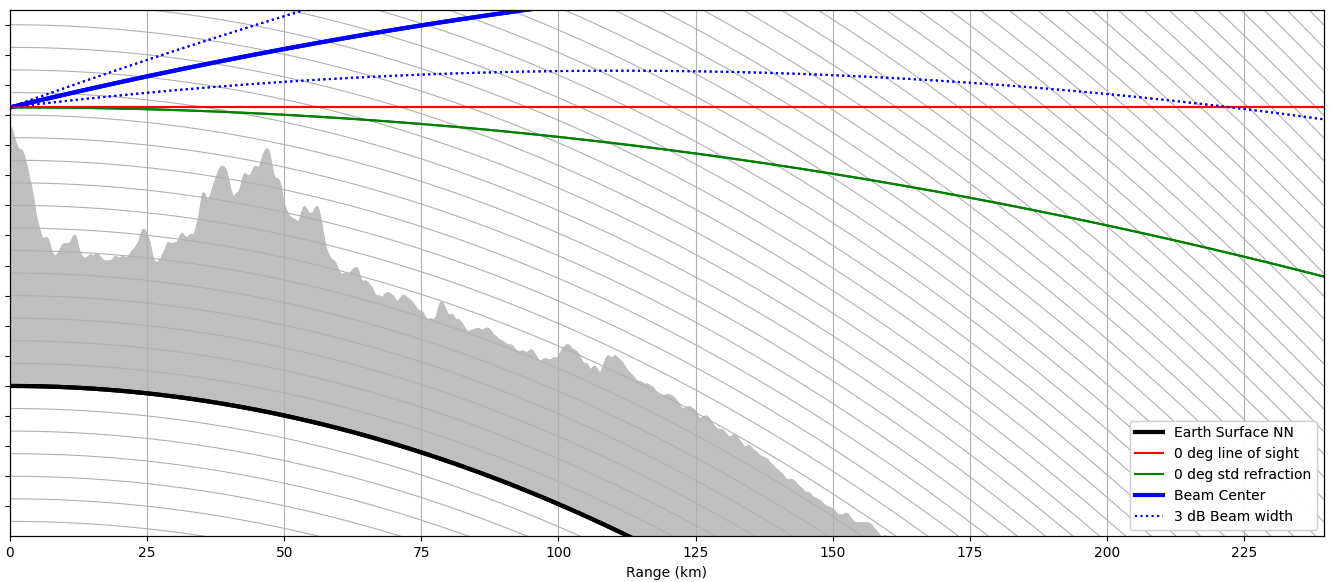

In [ ]:
fig = plt.figure(figsize=(14, 6))

cgax, caax, paax = wrl.vis.create_cg(fig=fig, rot=0, scale=1)

# azimuth angle
#angle = 225
angle = int(fwd_azimuth_graus)

# fix grid_helper
er = 6370000
gh = cgax.get_grid_helper()
gh.grid_finder.grid_locator2._nbins = 80
gh.grid_finder.grid_locator2._steps = [1, 2, 4, 5, 10]

# calculate beam_height and arc_distance for ke=1
# means line of sight
bhe = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er, ke=1.0)
ade = wrl.georef.bin_distance(r, 0, sitecoords[2], re=er, ke=1.0)
nn0 = np.zeros_like(r)

# for nice plotting we assume earth_radius = 6370000 m
ecp = nn0 + er

# theta (arc_distance sector angle)
thetap = -np.degrees(ade / er) + 90.0

# zero degree elevation with standard refraction
bh0 = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er)

# plot (ecp is earth surface normal null)
(bes,) = paax.plot(thetap,
                   ecp,
                   "-k",
                   linewidth=3,
                   label="Earth Surface NN")

(bc,) = paax.plot(thetap, ecp + alt[angle, :],
                  "-b",
                  linewidth=3,
                  label="Beam Center")

(bc0r,) = paax.plot(thetap,
                    ecp + bh0 + alt[angle, 0] - sitecoords[2],
                    "-g",
                    label="0 deg Refraction")

(bc0n,) = paax.plot(thetap,
                    ecp + bhe + alt[angle, 0] - sitecoords[2],
                    "-r",
                    label="0 deg line of sight")

(b3db,) = paax.plot(thetap, ecp + alt[angle, :] + beamradius,
                    ":b",
                    label="+3 dB Beam width")

paax.plot(thetap,
          ecp + alt[angle, :] - beamradius,
          ":b",
          label="-3 dB Beam width")

# orography
paax.fill_between(thetap,
                  ecp, ecp + polarvalues[angle, :],
                  color="0.75")

# shape axes
cgax.set_xlim(0, np.max(ade))
cgax.set_ylim([ecp.min() - 1000, ecp.max() + 2500])
caax.grid(True, axis="x")
cgax.grid(True, axis="y")
cgax.axis["top"].toggle(all=False)
caax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(steps=[1, 2, 4, 5, 10], nbins=20, prune="both"))
caax.xaxis.set_major_locator(mpl.ticker.MaxNLocator())
caax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(height_formatter))
caax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(range_formatter))

caax.set_xlabel("Range (km)")
caax.set_ylabel("Altitude (km)")

legend = paax.legend((bes, bc0n, bc0r, bc, b3db),
                     ("Earth Surface NN",
                      "0 deg line of sight",
                      "0 deg std refraction",
                      "Beam Center",
                      "3 dB Beam width"),
                     loc="lower right",
                     fontsize=10)

# recorta figura
plt.tight_layout()

# salva figura
plt.savefig(f'{dir}/output/codigo_3_Fig_2_beam_block_radarLNA_bandaS_azimute_{angle}graus.jpg',
            dpi=300,
            bbox_inches='tight')

In [ ]:
[ecp.min() - 1000, ecp.max() + 2500]

[np.int64(6369000), np.int64(6372500)]

Go back to [Read DEM Raster Data](#Read-DEM-Raster-Data), change the rasterfile to use the other resolution DEM and process again.